In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pymongo import MongoClient

In [75]:
# connect to mongo db
client = MongoClient('mongodb://localhost:27017/')
db = client.pokemon_db
# get pokemon base data collection
col_pokemon = db['pokemon_move']
pokemon_base = pd.DataFrame(list(col_pokemon.find())).drop(columns=['_id'])
# get move data collection
col_move_data = db['move_data']
move_base = pd.DataFrame(list(col_move_data.find()))
# connect to pokemon evolve data in mongoDB
col_evl = db['pokemon_evolve']
evolution_base = pd.DataFrame(list(col_evl.find()))

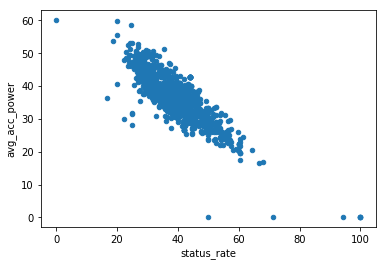

In [6]:
pokemon_df = pokemon_base.drop(columns=['move_name', 'catch_rate_avg']).fillna(0)
pokemon_df.plot.scatter(x='status_rate', y='avg_acc_power')

# use status rate and average accurate power to pull as linear data model

In [3]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [4]:
# create linear regression model 
model = linear_model.LinearRegression()

In [7]:
# split train and test data
X = pokemon_df.status_rate.values.reshape(-1, 1)
y = pokemon_df.avg_acc_power.values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [8]:
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [9]:
prediction = model.predict(X_test)

In [10]:
MSE = mean_squared_error(y_test, prediction)
r2 = model.score(X_test, y_test)
print(f"MSE: {MSE}, R2: {r2}")

MSE: 14.048270874968269, R2: 0.7645391008686304


In [11]:
# RANSACRegressor model test
# RANSACRegressor gets a slightly higher score
ransacr_model = linear_model.RANSACRegressor(random_state=0).fit(X_train, y_train)
ransacr_predict = ransacr_model.predict(X_test)
ransacr_mse = mean_squared_error(y_test, ransacr_predict)
ransacr_score = ransacr_model.score(X_test, y_test)
print(f"ransacr_mse: {ransacr_mse}, ransacr_score: {ransacr_score}")

ransacr_mse: 13.951477394183266, ransacr_score: 0.7661614414554923


In [12]:
pokemon_encountable = pokemon_df.loc[pokemon_df.area != 0]
X_encountable = pokemon_encountable.status_rate.values.reshape(-1, 1)
y_encountable = pokemon_encountable.avg_acc_power.values.reshape(-1, 1)
X_e_train, X_e_test, y_e_train, y_e_test = train_test_split(X_encountable, y_encountable)

ransacr_model2 = linear_model.RANSACRegressor(random_state=0).fit(X_e_train, y_e_train)
ransacr_predict2 = ransacr_model.predict(X_e_test)
ransacr_mse2 = mean_squared_error(y_e_test, ransacr_predict2)
ransacr_score2 = ransacr_model.score(X_e_test, y_e_test)
print(f"ransacr_mse2: {ransacr_mse2}, ransacr_score2: {ransacr_score2}")

ransacr_mse2: 18.88801211005656, ransacr_score2: 0.5600932475151469


# Move Power Feature by Type
#import move_by_type.csv

In [13]:
move_by_type = pd.read_csv('move_by_type.csv').drop(columns=['Unnamed: 0'])

In [14]:
unique_move = move_by_type.groupby('move_name').category.unique().to_frame().reset_index().rename(columns={'category': 'move_list'})

In [15]:
cat_len_list = []
for index, item in enumerate(unique_move.iterrows()):
    cat_len = len(item[1]['move_list'])
    cat_len_list.append(cat_len)
    
unique_move['cat_num'] = cat_len_list

In [16]:
move_by_type_full = move_by_type.merge(unique_move, on='move_name', how='left')

In [29]:
move_df = move_base.drop(columns=['_id', 'category', 'contest_type', 'damage_move'])

In [112]:
move_by_type_merge = move_by_type_full.merge(move_df, on='move_name', how='left').rename(columns={'category': 'type', 'cat_num': 'type_len'})

In [113]:
move_by_type_merge = move_by_type_merge.rename(columns={'move_num': 'pokemon_num'}).drop(columns=['count', 'move_list'])

In [114]:
move_by_type_merge.head()

,type,move_name,pokemon_num,move_rate,type_len,acc_power,accuracy,damage_class,power
0,poison,absorb,9,17.65,13,20.0,100.0,special,20.0
1,poison,acid,12,23.53,9,40.0,100.0,special,40.0
2,poison,acid-armor,3,5.88,9,0.0,0.0,status,0.0
3,poison,acid-spray,12,23.53,9,40.0,100.0,special,40.0
4,poison,acrobatics,4,7.84,16,55.0,100.0,physical,55.0


In [118]:
# save move_by_type_merge to mongodb
move_by_type_col = db['move_by_type']
move_by_type_col.insert_many(move_by_type_merge.to_dict('records'))

In [44]:
# filter the most common
top_common_move = move_df.sort_values(by='count', ascending=False)[:13]
top_attack_move = move_df.loc[move_df.acc_power != 0].sort_values(by='count', ascending=False)[:3]

In [66]:
# each type's avg attack power after remove most common attack move 
top_move = move_by_type_merge.loc[move_by_type_merge.acc_power > 0].loc[move_by_type_merge.move_rate >= 95]
filt_top_move = top_move
for move in top_attack_move.move_name:
    con = top_move.move_name != move
    filt_top_move = filt_top_move[con]
    
# each type's unique move(not share with other types)
filt_top_move

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,type,move_name,move_num,move_rate,move_list,type_len,acc_power,accuracy,count,damage_class,power
265,poison,sludge-bomb,49,96.08,"[poison, fire, flying, water, bug, normal, ele...",17,90.0,100.0,166.0,special,90.0
330,poison,venoshock,49,96.08,"[poison, fire, flying, water, bug, normal, gro...",14,65.0,100.0,104.0,special,65.0
453,fire,fire-blast,45,97.83,"[poison, fire, flying, water, normal, electric...",17,93.5,85.0,196.0,special,110.0
464,fire,flamethrower,45,97.83,"[poison, fire, flying, water, normal, electric...",17,90.0,100.0,217.0,special,90.0
559,fire,overheat,45,97.83,"[fire, flying, water, normal, electric, ground...",14,117.0,90.0,90.0,special,130.0
1606,bug,bug-bite,24,100.00,"[poison, fire, flying, water, bug, electric, g...",15,60.0,100.0,92.0,physical,60.0
2274,electric,charge-beam,52,96.30,"[poison, fire, flying, water, bug, normal, ele...",17,45.0,90.0,236.0,special,50.0
2540,electric,thunderbolt,53,98.15,"[poison, fire, flying, water, bug, normal, ele...",18,90.0,100.0,279.0,special,90.0
2598,ground,bulldoze,54,98.18,"[poison, fire, flying, water, bug, normal, ele...",18,60.0,100.0,336.0,physical,60.0
2639,ground,earthquake,53,96.36,"[poison, fire, flying, water, bug, normal, ele...",18,100.0,100.0,311.0,physical,100.0


In [69]:
filt_top_move.groupby('type').mean().sort_values(by='acc_power', ascending=False)

,move_num,move_rate,type_len,acc_power,accuracy,count,power
type,,,,,,,
grass,64.0,98.460,17.5,105.000000,100.000000,271.000000,105.0
fire,45.0,97.830,16.0,100.166667,91.666667,167.666667,110.0
ice,29.5,98.335,18.0,83.500000,85.000000,271.500000,100.0
dark,36.0,97.300,17.0,80.000000,100.000000,186.000000,80.0
ground,53.5,97.270,18.0,80.000000,100.000000,323.500000,80.0
poison,49.0,96.080,15.5,77.500000,100.000000,135.000000,77.5
electric,52.5,97.225,17.5,67.500000,95.000000,257.500000,70.0
rock,28.0,100.000,18.0,62.250000,92.500000,391.000000,67.5
bug,24.0,100.000,15.0,60.000000,100.000000,92.000000,60.0


In [70]:
# top accurate power by type
top_move.groupby('type').mean().sort_values(by='acc_power', ascending=False)

,move_num,move_rate,type_len,acc_power,accuracy,count,power
type,,,,,,,
fire,45.500000,98.915000,17.00,81.750000,95.833333,553.000000,86.666667
grass,64.600000,99.384000,17.80,80.000000,100.000000,671.400000,80.000000
ice,29.800000,99.334000,18.00,71.400000,94.000000,671.600000,78.000000
ground,54.400000,98.908000,18.00,70.000000,100.000000,692.400000,70.000000
poison,49.000000,96.080000,17.00,69.000000,100.000000,617.000000,69.000000
dark,36.750000,99.325000,17.75,67.500000,100.000000,750.250000,67.500000
ghost,31.000000,100.000000,18.00,65.000000,100.000000,938.000000,65.000000
electric,52.800000,97.780000,17.80,65.000000,98.000000,666.000000,66.000000
steel,36.666667,99.100000,18.00,63.333333,100.000000,938.333333,63.333333


In [32]:
move_by_type_merge.loc[move_by_type_merge.acc_power > 0].groupby('type').mean().sort_values(by='acc_power', ascending=False)

,move_num,move_rate,type_len,acc_power,accuracy,count,power
type,,,,,,,
ghost,5.438202,17.543539,13.252809,72.304213,96.376404,152.101124,75.550562
fairy,9.021053,15.826211,13.363158,72.107895,95.921053,153.157895,75.921053
dragon,6.681159,18.559710,13.231884,71.746377,95.458937,142.932367,75.797101
psychic,12.525581,16.267535,13.353488,71.516279,96.139535,143.497674,74.953488
ice,6.030120,20.099759,14.186747,71.284036,95.692771,166.265060,75.108434
normal,13.636364,18.426955,13.200000,71.124773,95.340909,139.781818,75.095455
fire,8.517766,18.516193,13.365482,70.981726,95.076142,147.005076,75.395939
rock,6.620915,23.645490,14.673203,70.689542,94.934641,173.287582,75.163399
ground,10.403941,18.915862,13.694581,70.669458,95.615764,146.615764,74.472906


In [33]:
move_by_type_merge.groupby('type').mean().sort_values(by='acc_power', ascending=False)

,move_num,move_rate,type_len,acc_power,accuracy,count,power
type,,,,,,,
dragon,6.928358,19.246328,13.561194,44.332836,73.283582,167.543284,48.000000
ground,11.051205,20.092982,13.885542,43.210542,73.132530,168.484940,46.469880
ghost,6.541401,21.102389,13.385350,40.987739,69.522293,170.824841,44.452229
dark,8.026946,21.694132,13.553892,40.856886,71.362275,168.419162,44.269461
steel,6.542522,17.682522,13.510264,40.802493,70.689150,166.621701,44.246334
rock,6.970037,24.892322,14.516854,40.507491,68.539326,190.588015,44.194757
electric,9.386503,17.382331,13.714724,39.773466,70.782209,168.662577,42.892638
fighting,11.141689,20.258120,13.122616,39.704223,70.177112,156.585831,42.931880
fire,8.511173,18.501983,13.329609,39.059777,68.882682,159.578212,42.606145


In [74]:
none_status = move_by_type_merge.loc[move_by_type_merge.damage_class != 'status']
none_status.groupby('type').mean().sort_values(by='acc_power', ascending=False)

,move_num,move_rate,type_len,acc_power,accuracy,count,power
type,,,,,,,
dragon,6.820513,18.946752,13.320513,63.467949,92.307692,149.645299,68.717949
ghost,5.686275,18.343725,13.230392,63.088971,92.916667,158.387255,68.421569
dark,7.894009,21.335023,13.612903,62.885714,93.133641,158.631336,68.138249
ground,10.743478,19.533261,13.813043,62.373478,92.869565,153.643478,67.078261
psychic,13.024194,16.915121,13.379032,62.000000,91.975806,147.685484,66.955645
fairy,9.434389,16.551357,13.330317,61.993213,91.787330,157.090498,67.488688
grass,10.277273,15.811727,13.927273,61.840455,93.568182,160.477273,66.195455
normal,13.988235,18.902353,13.180392,61.362549,91.823529,143.223529,66.356863
rock,6.661017,23.788814,14.632768,61.104520,91.440678,177.344633,66.666667


# drango type 

In [24]:
dragon_df = pokemon_df.loc[pokemon_df.type == 'dragon']

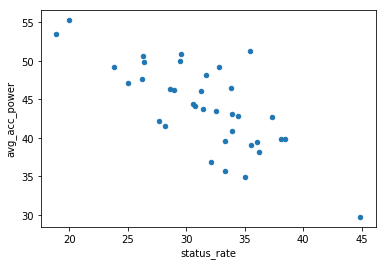

In [26]:
dragon_df.plot.scatter(x='status_rate', y='avg_acc_power')

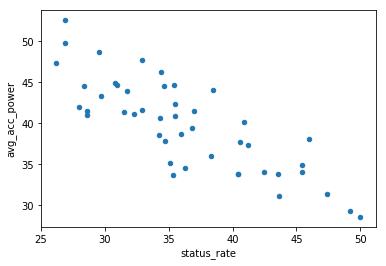

In [71]:
fire_df = pokemon_df.loc[pokemon_df.type == 'fire']
fire_df.plot.scatter(x='status_rate', y='avg_acc_power')

# Combine with Evoluation data

In [76]:
evolution_df = evolution_base.drop(columns=['_id'])

In [90]:
pokemon_evol_list = []
for index, row in evolution_df.iterrows():
    chain_len = row[2]
    chain = row[0]
    chain_id = row[1]

    if chain_len == 1:
        pokemon_evol_list.append({'name': chain[0], 'evolution': '0-0', 'evol_id': chain_id})
    if chain_len == 2:
        pokemon_evol_list.append({'name': chain[0], 'evolution': '2-1', 'evol_id': chain_id})
        pokemon_evol_list.append({'name': chain[1], 'evolution': '2-2', 'evol_id': chain_id})
    if chain_len == 3:
        pokemon_evol_list.append({'name': chain[0], 'evolution': '3-1', 'evol_id': chain_id})
        pokemon_evol_list.append({'name': chain[1], 'evolution': '3-2', 'evol_id': chain_id})
        pokemon_evol_list.append({'name': chain[2], 'evolution': '3-3', 'evol_id': chain_id})

In [91]:
pokemon_evol_df = pd.DataFrame(pokemon_evol_list)

In [94]:
pokemon_df_full = pokemon_df.merge(pokemon_evol_df, on='name', how='left')

In [96]:
pokemon_df_full.evol_id = pokemon_df_full.evol_id.fillna(-1)
pokemon_df_full.evolution = pokemon_df_full.evolution.fillna('n.a')